In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION ---
DETAILS_CSV = "wikipedia/experiments/run_20251212_095946/results/canary_details_full.csv"
ORIGINAL_CANARIES_CSV = "memorization/canaries.csv" 

# --- HELPER FUNCTIONS ---
def calculate_dynamic_threshold(scores, fpr_target=0.10):
    if len(scores) == 0: return float('inf')
    return np.percentile(scores, (1 - fpr_target) * 100)

def analyze_subset_metrics(df_subset):
    stats = []
    epochs = sorted(df_subset['epoch'].unique())
    for epoch in epochs:
        df_epoch = df_subset[df_subset['epoch'] == epoch]
        val_data = df_epoch[df_epoch['split'] == 'validation']
        train_data = df_epoch[df_epoch['split'] == 'train']
        
        if len(val_data) == 0 or len(train_data) == 0: continue
            
        tau = calculate_dynamic_threshold(val_data['mia_score'].values, fpr_target=0.10)
        
        is_memorized = train_data['mia_score'] > tau
        mia_recall = is_memorized.sum() / len(train_data)
        avg_ctx = train_data['contextual_score'].mean()
        avg_cf = train_data['counterfactual_score'].mean()
        
        stats.append({
            'epoch': epoch, 'mia_recall': mia_recall, 
            'contextual_score': avg_ctx, 'counterfactual_score': avg_cf
        })
    return pd.DataFrame(stats)

def plot_comparison(df_stats, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_stats, x='epoch', y='mia_recall', label='MIA Recall', linewidth=3, marker='o', color='crimson')
    sns.lineplot(data=df_stats, x='epoch', y='counterfactual_score', label='Counterfactual', linewidth=2, linestyle='-.', marker='v', color='green', alpha=0.7)
    sns.lineplot(data=df_stats, x='epoch', y='contextual_score', label='Contextual', linewidth=3, linestyle='--', marker='s', color='royalblue')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Training Epochs"); plt.ylabel("Score (0.0 - 1.0)"); plt.ylim(-0.05, 1.05)
    plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

In [7]:
if not os.path.exists(DETAILS_CSV) or not os.path.exists(ORIGINAL_CANARIES_CSV):
    print("❌ ERROR: Files not found.")
else:
    print("✅ Loading files...")
    df_details = pd.read_csv(DETAILS_CSV)
    df_meta = pd.read_csv(ORIGINAL_CANARIES_CSV)

    # Merge to get 'type' column
    df_merged = pd.merge(df_details, df_meta[['canary_id', 'type']], on='canary_id', how='left')
    print(f"Merged Data Ready: {len(df_merged)} rows.")

✅ Loading files...
Merged Data Ready: 1200 rows.


Generating High Entropy Plot...


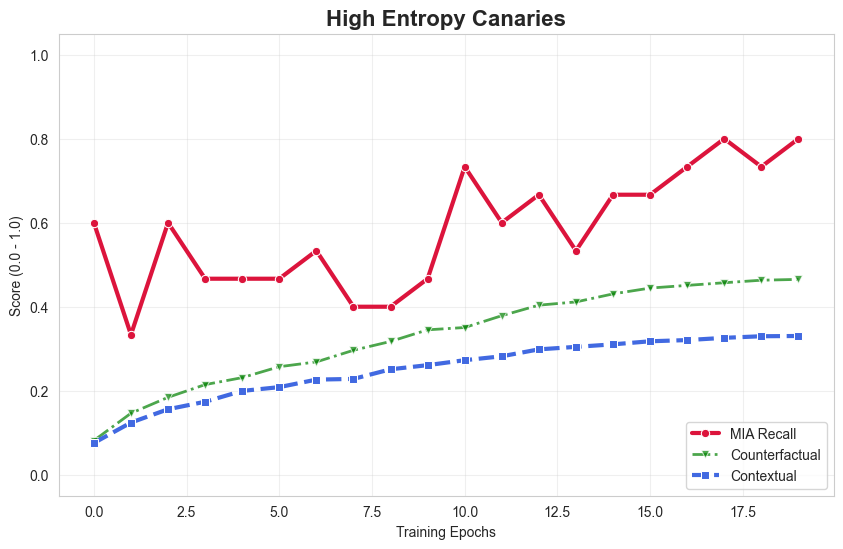

In [8]:
# --- PLOT 1: HIGH ENTROPY ---
df_high = df_merged[df_merged['type'] == 'high_entropy']
if not df_high.empty:
    print("Generating High Entropy Plot...")
    stats_high = analyze_subset_metrics(df_high)
    plot_comparison(stats_high, "High Entropy Canaries")


Generating Low Entropy Plot...


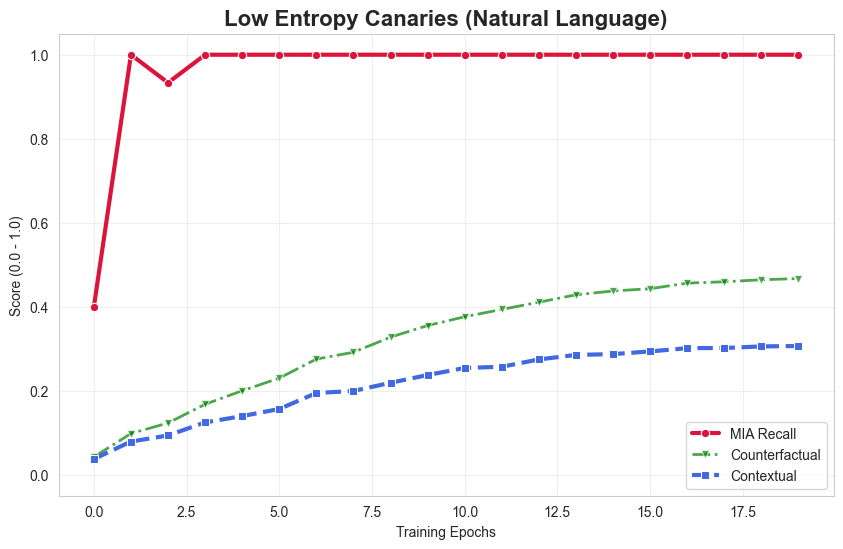

In [9]:
# --- PLOT 2: LOW ENTROPY ---
df_low = df_merged[df_merged['type'] == 'low_entropy']
if not df_low.empty:
    print("Generating Low Entropy Plot...")
    stats_low = analyze_subset_metrics(df_low)
    plot_comparison(stats_low, "Low Entropy Canaries (Natural Language)")